# 4.2 - Multiclass Classification With Reuters Dataset

* [4.2.1 - The Reuters Dataset](#first-bullet)
* [4.2.2 - Preparing the Data](#second-bullet)
* [4.2.3 - Building Your Model](#third-bullet)
* [4.2.4 - Further Experiments](#fourth-bullet)

We explored a binary classification example with the IMDB dataset in chapter 4.1, but what if we have more than two classes?  This example will classify Reuters data into 46 distinct, mutually exclusive categories.

## 4.2.1 - The Reuters Dataset <a class="anchor" id="first-bullet"></a>

The Reuters dataset has 46 classes with at least 10 examples per class.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

We have 8982 training examples and 2246 validation examples in the dataset.

In [2]:
print(len(train_data))
print(len(test_data))

8982
2246


Like our IMDB example, our words have been encoded as the 10,000 most common words.

In [3]:
print(train_data[10])

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]


And like our IMDB example, we can translate back from integer representation back to the actual words, keeping note that our translation is offset by 3 for the three special representations in our word index for padding, sequence starts, and unknown words.

In [4]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in
    train_data[0]])

print(decoded_newswire)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


Our articles are also classified as integers.  Let's get the classification of the data at index 10.

In [5]:
train_labels[10]

3

## 4.2.2 - Preparing the Data <a class="anchor" id="second-bullet"></a>

Like our binary classification example, we will utilize one-hot encoding on vectors of length 10,000.

In [6]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

We will also use one-hot encoding for our 46 different labels.

In [7]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

print(one_hot_train_labels[0])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Or, we can use built in functionality of Keras to do the one-hot encoding for us instead of defining our own function.

In [8]:
from tensorflow.keras.utils import to_categorical
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

print(one_hot_train_labels[0])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## 4.2.3 - Building Your Model <a class="anchor" id="third-bullet"></a>

Our original binary classification example used two representation layers of 16 units.  Since our problem is a bit more complicated (46 classes instead of 2), we will experiment with representation `Dense` layers of 64 units.

We also need to increase our output layer from 1 for a binary classification model to 46 for our multiclass classification problem.

In [9]:
model = keras.Sequential([
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(46, activation='softmax')
])

Our loss function also needs to change when we compile our model.  `categorical_crossentropy` will be used instead of `binary_crossentropy` because we want to minimize the distance between the probabilities in our output vector and the probabilities of our true labels.

For example, if we had five classes where the data belonged to class 3, then the probabilities of our true labels would be [0, 0, 1, 0, 0].

In [10]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

We will set aside some of our data for validation to ensure we are not over-fitting out model.

In [11]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Train the model.

In [12]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 2s 113ms/step - loss: 2.6932 - accuracy: 0.5172 - val_loss: 1.7759 - val_accuracy: 0.6560
Epoch 2/20
16/16 [==============================] - 1s 89ms/step - loss: 1.4227 - accuracy: 0.7119 - val_loss: 1.2883 - val_accuracy: 0.7340
Epoch 3/20
16/16 [==============================] - 1s 82ms/step - loss: 1.0289 - accuracy: 0.7805 - val_loss: 1.1115 - val_accuracy: 0.7670
Epoch 4/20
16/16 [==============================] - 1s 79ms/step - loss: 0.8100 - accuracy: 0.8311 - val_loss: 1.0313 - val_accuracy: 0.7780
Epoch 5/20
16/16 [==============================] - 1s 69ms/step - loss: 0.6476 - accuracy: 0.8632 - val_loss: 0.9702 - val_accuracy: 0.7890
Epoch 6/20
16/16 [==============================] - 1s 53ms/step - loss: 0.5221 - accuracy: 0.8885 - val_loss: 0.9243 - val_accuracy: 0.8090
Epoch 7/20
16/16 [==============================] - 1s 42ms/step - loss: 0.4236 - accuracy: 0.9112 - val_loss: 0.8870 - val_accuracy: 0.8180
Epoch 8/20
1

And examine our test versus validation loss, and test versus validation accuracy.

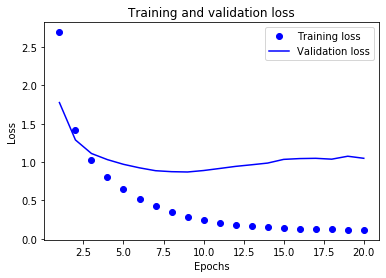

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

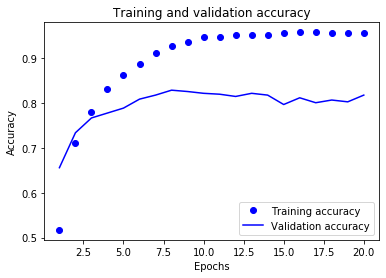

In [14]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We can use our model's `predict` method to generate new predictions.  Each prediction is a vector of length 46.  Each prediction vector holds the probabilities that the prediction will be of that class and must sum to 1.  Our class is the category with the highest probability.

In [15]:
predictions = model.predict(x_test)
print(predictions[0].shape)
print(predictions[0])
print(np.sum(predictions[0]))
print(np.argmax(predictions[0]))

(46,)
[1.23535006e-06 6.98570466e-06 1.54562343e-07 9.91652548e-01
 5.36475284e-03 1.78851860e-06 2.98501618e-06 2.32907696e-05
 6.02774322e-04 1.61006428e-05 7.41176154e-06 6.90757297e-04
 3.26923532e-06 9.68047789e-06 5.66445976e-07 1.56255766e-07
 1.66999453e-04 1.15687571e-05 7.55498331e-06 4.25202365e-04
 6.58058736e-04 1.34851143e-05 5.21369702e-06 1.45261106e-06
 4.48183428e-08 5.38262725e-07 1.05774937e-07 1.64754965e-07
 1.49295511e-05 1.61553305e-06 3.07150949e-05 1.43680529e-06
 1.02816475e-05 4.15554979e-07 5.34615401e-06 3.49041649e-08
 2.25773430e-04 9.58694091e-06 1.27960334e-07 9.63886578e-06
 8.13252973e-06 4.77848835e-06 2.31060142e-07 4.28198575e-07
 1.46561190e-08 1.53907274e-06]
0.9999999
3


## 4.2.4 - Further Experiments <a class="anchor" id="fourth-bullet"></a>

Let's go for broke, if two representation layers of 64 units is good, then surely doubling the number of layers and units will be better!

In [16]:
model = keras.Sequential([
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(46, activation='softmax')
])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 2s 155ms/step - loss: 2.2883 - accuracy: 0.4989 - val_loss: 1.5874 - val_accuracy: 0.6080
Epoch 2/20
16/16 [==============================] - 1s 85ms/step - loss: 1.2544 - accuracy: 0.7097 - val_loss: 1.2551 - val_accuracy: 0.6880
Epoch 3/20
16/16 [==============================] - 1s 60ms/step - loss: 0.9306 - accuracy: 0.7796 - val_loss: 1.0591 - val_accuracy: 0.7640
Epoch 4/20
16/16 [==============================] - 1s 61ms/step - loss: 0.6874 - accuracy: 0.8430 - val_loss: 1.1246 - val_accuracy: 0.7730
Epoch 5/20
16/16 [==============================] - 1s 56ms/step - loss: 0.5336 - accuracy: 0.8779 - val_loss: 1.0379 - val_accuracy: 0.7800
Epoch 6/20
16/16 [==============================] - 1s 56ms/step - loss: 0.4104 - accuracy: 0.9067 - val_loss: 1.0313 - val_accuracy: 0.8030
Epoch 7/20
16/16 [==============================] - 1s 67ms/step - loss: 0.3262 - accuracy: 0.9223 - val_loss: 1.0669 - val_accuracy: 0.7860
Epoch 8/20
1

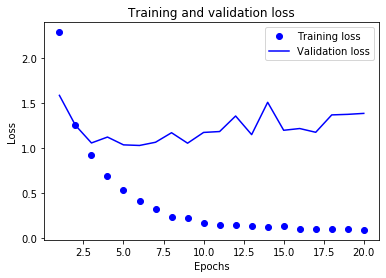

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

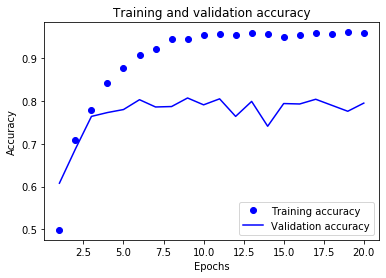

In [18]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

No really.  Perhaps we need to learn about layer types other than `Dense`, and playing around with different optimizers, learning rates, and regularization.